# Exploratory Analysis Part 2

In part 1, we explored what factors could lead to the changes in price level of HDB prices. For the purposes of this exploration part 2, I have filtered HDBs that are purely residential. This is in order to create the bid rent curve for urban economics analysis purposes. 

But before that it is important to ensure all the econometrics assumptions have been met. In this notebook, each assumption is explored and analysed. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()
from sklearn import preprocessing
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from collections import Counter
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
mmScaler = MinMaxScaler()
sScaler = StandardScaler()
pd.options.mode.chained_assignment = None  # default='warn'
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats import chi2

In [2]:
residential = pd.read_csv('residential.csv', low_memory=False, index_col=1)

In [3]:
residential.columns

Index(['True', 'town', 'flat_type', 'blk_no', 'street', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'remaining_lease', 'resale_price', 'max_floor_lvl', 'year_completed',
       'residential', 'commercial', 'market_hawker', 'miscellaneous',
       'multistorey_carpark', 'precinct_pavilion', 'bldg_contract_town',
       'total_dwelling_units', '1room_sold', '2room_sold', '3room_sold',
       '4room_sold', '5room_sold', 'exec_sold', 'multigen_sold',
       'studio_apartment_sold', '1room_rental', '2room_rental', '3room_rental',
       'other_room_rental', 'building', 'addr', 'Postal', 'SUBZONE_NO',
       'SUBZONE_N', 'PLN_AREA_N', 'REGION_N', 'MRT_NAME', 'mrt_line',
       'mahattan_distance', 'mrt_cbd_dist', 'mrt_cbd_time', 'hdb_cbd_distance',
       'hdb_cbd_time', 'hdb_to_mrtdist', 'sgd_persqm', 'No_Bus_Stops',
       'real_price', 'real_price_persqm', 'lease_remaining', 'Floor_Height'],
      dtype='object')

take a pause here:
floor area multiplied by the sgd per sqm will equal the resale price
similarly
floor area multiplied by the real price sqm will equal the real price

Hence, remove floor area, real price per sqm, nominal sgd per sqm. 

# Before we remove.... lets see what relationships they have 


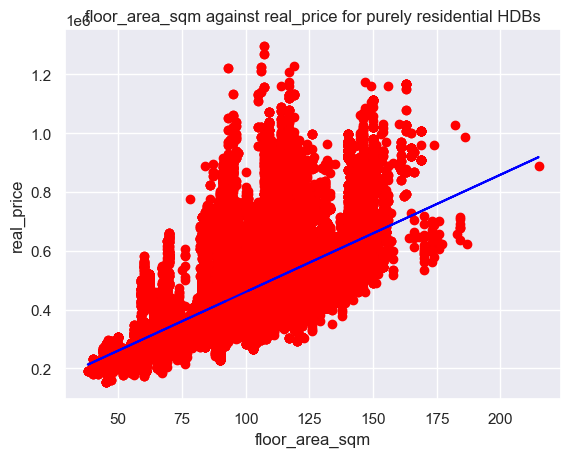

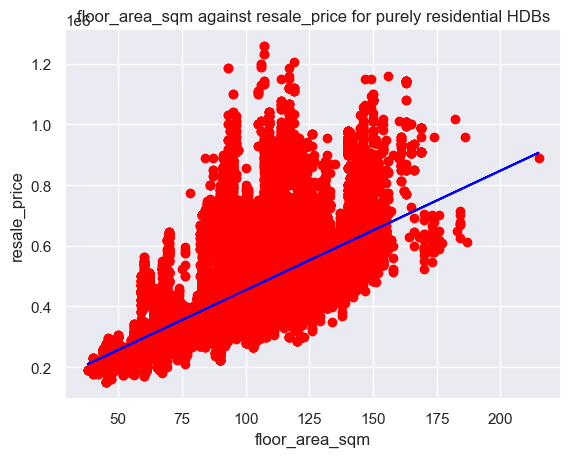

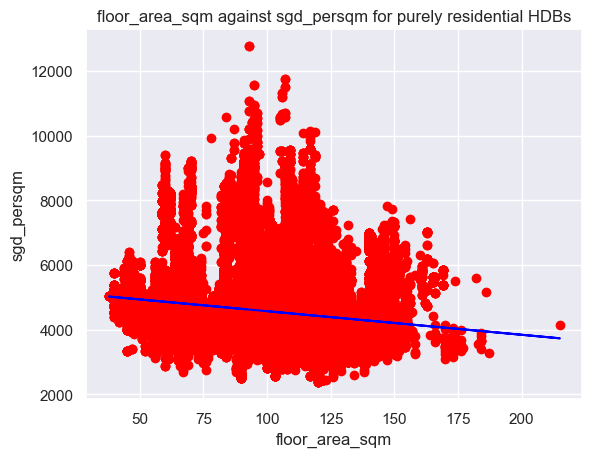

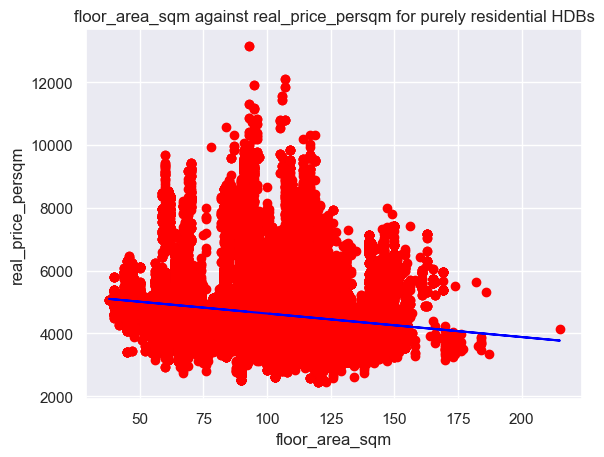

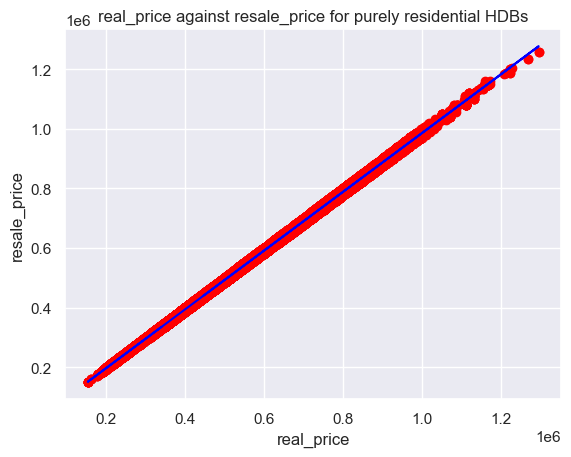

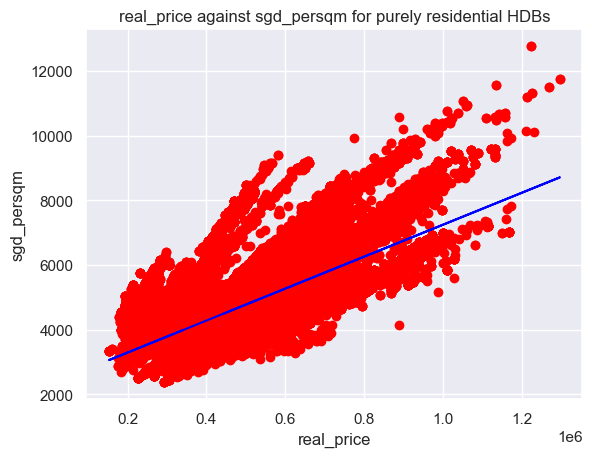

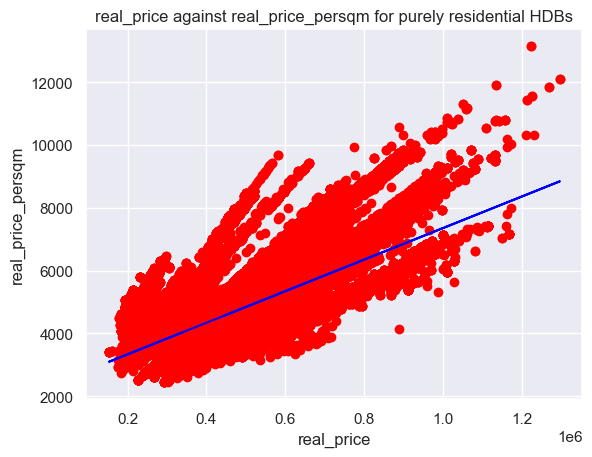

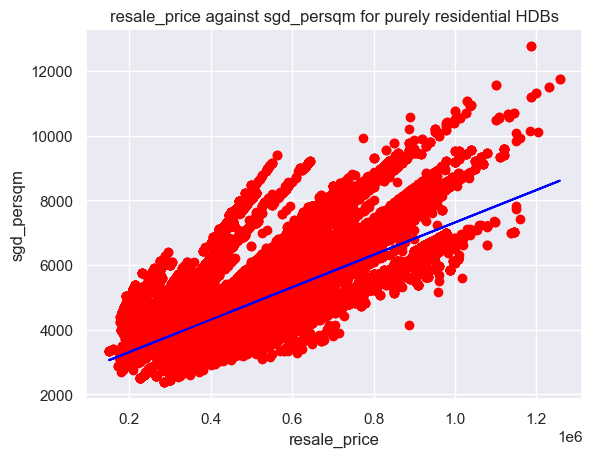

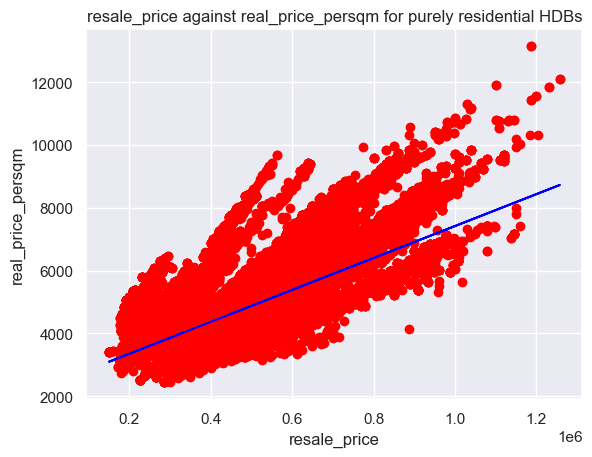

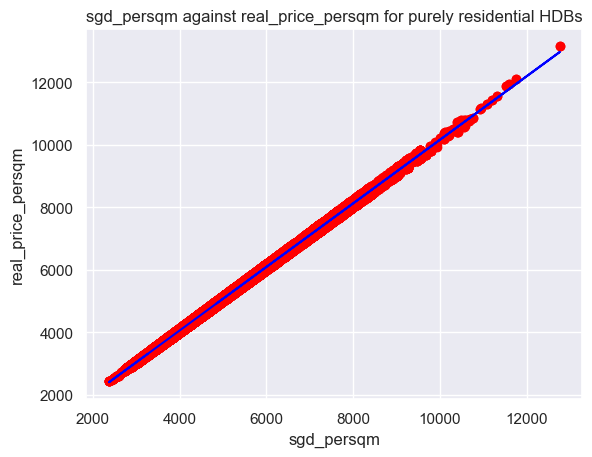

In [4]:
def printgraph(x:str,y:str):
    X=residential[[x]]
    Y=residential[[y]]
    
    titlestr = x + ' against ' + y + ' for purely residential HDBs'

    regressor = LinearRegression()
    regressor.fit(X,Y)
    y_pred = regressor.predict(X)
    plt.scatter(X, Y, color = 'red', )
    plt.plot(X, regressor.predict(X), color = 'blue')
    plt.title(titlestr)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

    
llist = ['floor_area_sqm','real_price', 'resale_price', 'sgd_persqm', 'real_price_persqm']

for i in range(0, len(llist)):
    for j in range(i+1, len(llist)):
        printgraph(llist[i], llist[j])

In [5]:
#residential = residential.drop('real_price', axis=1) # due to exact relationship with resale price 
#residential = residential.drop('sgd_persqm', axis=1) #due to exact relationship with y variable

In [9]:
residential

,True,town,flat_type,blk_no,street,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,...,No_Bus_Stops,real_price,real_price_persqm,lease_remaining,Floor_Height,real_price_k,hdb_cbd_distance_k,hdb_to_mrtdist_k,log-real_price,ln_real_price
month,,,,,,,,,,,,,,,,,,,,,
2017-03,0,BUKIT BATOK,4 ROOM,383,BT BATOK WEST AVE 5,07 TO 09,92.0,Model A,2005,86 years 11 months,...,0.0,445000.0,4836.9600,86.916667,8,445.000,445.000,445.000,13.005830,13.005830
2017-04,1,BUKIT BATOK,4 ROOM,383,BT BATOK WEST AVE 5,19 TO 21,90.0,Model A,2005,86 years 11 months,...,0.0,462888.0,5143.2000,86.916667,20,462.888,462.888,462.888,13.045240,13.045240
2017-05,2,BUKIT BATOK,4 ROOM,383,BT BATOK WEST AVE 5,01 TO 03,90.0,Model A,2005,86 years 10 months,...,0.0,395000.0,4388.8900,86.833333,2,395.000,395.000,395.000,12.886641,12.886641
2017-09,3,BUKIT BATOK,5 ROOM,383,BT BATOK WEST AVE 5,10 TO 12,115.0,Improved,2005,86 years 05 months,...,0.0,550000.0,4782.6100,86.416667,11,550.000,550.000,550.000,13.217674,13.217674
2017-12,4,BUKIT BATOK,4 ROOM,383,BT BATOK WEST AVE 5,10 TO 12,90.0,Model A,2005,86 years 03 months,...,0.0,413000.0,4588.8900,86.250000,11,413.000,413.000,413.000,12.931203,12.931203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-05,184928,CHOA CHU KANG,4 ROOM,152,JLN TECK WHYE,07 TO 09,101.0,Model A,1998,78 years 08 months,...,0.0,335320.0,3320.0013,78.666667,8,335.320,335.320,335.320,12.722841,12.722841
2018-08,184929,CHOA CHU KANG,4 ROOM,152,JLN TECK WHYE,13 TO 15,101.0,Model A,1998,78 years 05 months,...,0.0,378750.0,3749.9987,78.416667,14,378.750,378.750,378.750,12.844632,12.844632
2018-11,184930,CHOA CHU KANG,4 ROOM,152,JLN TECK WHYE,01 TO 03,100.0,Model A,1998,78 years 02 months,...,0.0,328250.0,3282.5000,78.166667,2,328.250,328.250,328.250,12.701531,12.701531


# Linear Regression on all possible x values (numerical)

In [10]:
def conversion(value):
    return value/1000.0

residential['real_price_k'] = residential.apply(lambda row: conversion(row.real_price), axis=1)
residential['hdb_cbd_distance_k'] = residential.apply(lambda row: conversion(row.hdb_cbd_distance), axis=1)
residential['hdb_to_mrtdist_k'] = residential.apply(lambda row: conversion(row.hdb_to_mrtdist), axis=1)
residential['ln_real_price'] = residential.apply(lambda row: np.log(row.real_price), axis=1)

col = 'real_price'
residential["log-" + col] = np.log(residential[col])


X = residential[['floor_area_sqm','No_Bus_Stops',
       'hdb_cbd_distance_k',
       'hdb_to_mrtdist_k',  'lease_remaining','Floor_Height']]

y = residential[['ln_real_price']]
X_constant = sm.add_constant(X)
lr = sm.OLS(y, X_constant.astype(float)).fit(cov_type='HC1') #using HC1 

print(lr.summary())
print("\nHeteroskedasticity test using breush pagan\n")
residuals_squared = lr.resid**2
bp_model = sm.OLS(residuals_squared, sm.add_constant(X)).fit()
df_resid = bp_model.df_resid
k_vars = bp_model.df_model
t_stat = bp_model.ssr/bp_model.mse_resid
p_val = chi2.sf(t_stat, k_vars)
print(f"BP test p-value: {p_val}")
print(bp_model.summary())
# print("\nRobust Standard Errors / Weighted Linear Regression\n")
# #cov_type='HC3'
# wls_model = sm.OLS(y, X_constant.astype(float)).fit(cov_type='HC3')
# print(wls_model.summary())

# print("-------------------------------------------------------------------------------------------\n")
# X = residential[['floor_area_sqm',
#        'mrt_cbd_time',
#        'hdb_to_mrtdist', 'No_Bus_Stops', 'lease_remaining','Floor_Height']]
# y = residential[['real_price']]
# X_constant = sm.add_constant(X)
# lr = sm.OLS(y, X_constant.astype(float)).fit(cov_type='HC1')
# print(lr.summary())

# print("\nHeteroskedasticity test using breush pagan\n")
# residuals_squared = lr.resid**2
# bp_model = sm.OLS(residuals_squared, sm.add_constant(X)).fit()
# df_resid = bp_model.df_resid
# k_vars = bp_model.df_model
# t_stat = bp_model.ssr/bp_model.mse_resid
# p_val = chi2.sf(t_stat, k_vars)
# print(f"BP test p-value: {p_val}")
# residuals_squared = lr.resid**2
# bp_model = sm.OLS(residuals_squared, sm.add_constant(X)).fit()
# df_resid = bp_model.df_resid
# k_vars = bp_model.df_model
# t_stat = bp_model.ssr/bp_model.mse_resid
# p_val = chi2.sf(t_stat, k_vars)
# print(f"BP test p-value: {p_val}")
# print(bp_model.summary())

# print("\nRobust Standard Errors / Weighted Linear Regression\n")
# #cov_type='HC3'
# wls_model = sm.OLS(y, X_constant.astype(float)).fit(cov_type='HC3')
# print(wls_model.summary())

                            OLS Regression Results                            
Dep. Variable:          ln_real_price   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                 5.420e+04
Date:                Wed, 12 Apr 2023   Prob (F-statistic):               0.00
Time:                        12:09:57   Log-Likelihood:                 62259.
No. Observations:              111026   AIC:                        -1.245e+05
Df Residuals:                  111019   BIC:                        -1.244e+05
Df Model:                           6                                         
Covariance Type:                  HC1                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 11.8007      0

# Analysis 

Whyyyy is almost all x variable affecting the y variable? there must be something wrong here!
But we now know multigen is no problem, hopefully...

# Possible Collinearity

<AxesSubplot:>

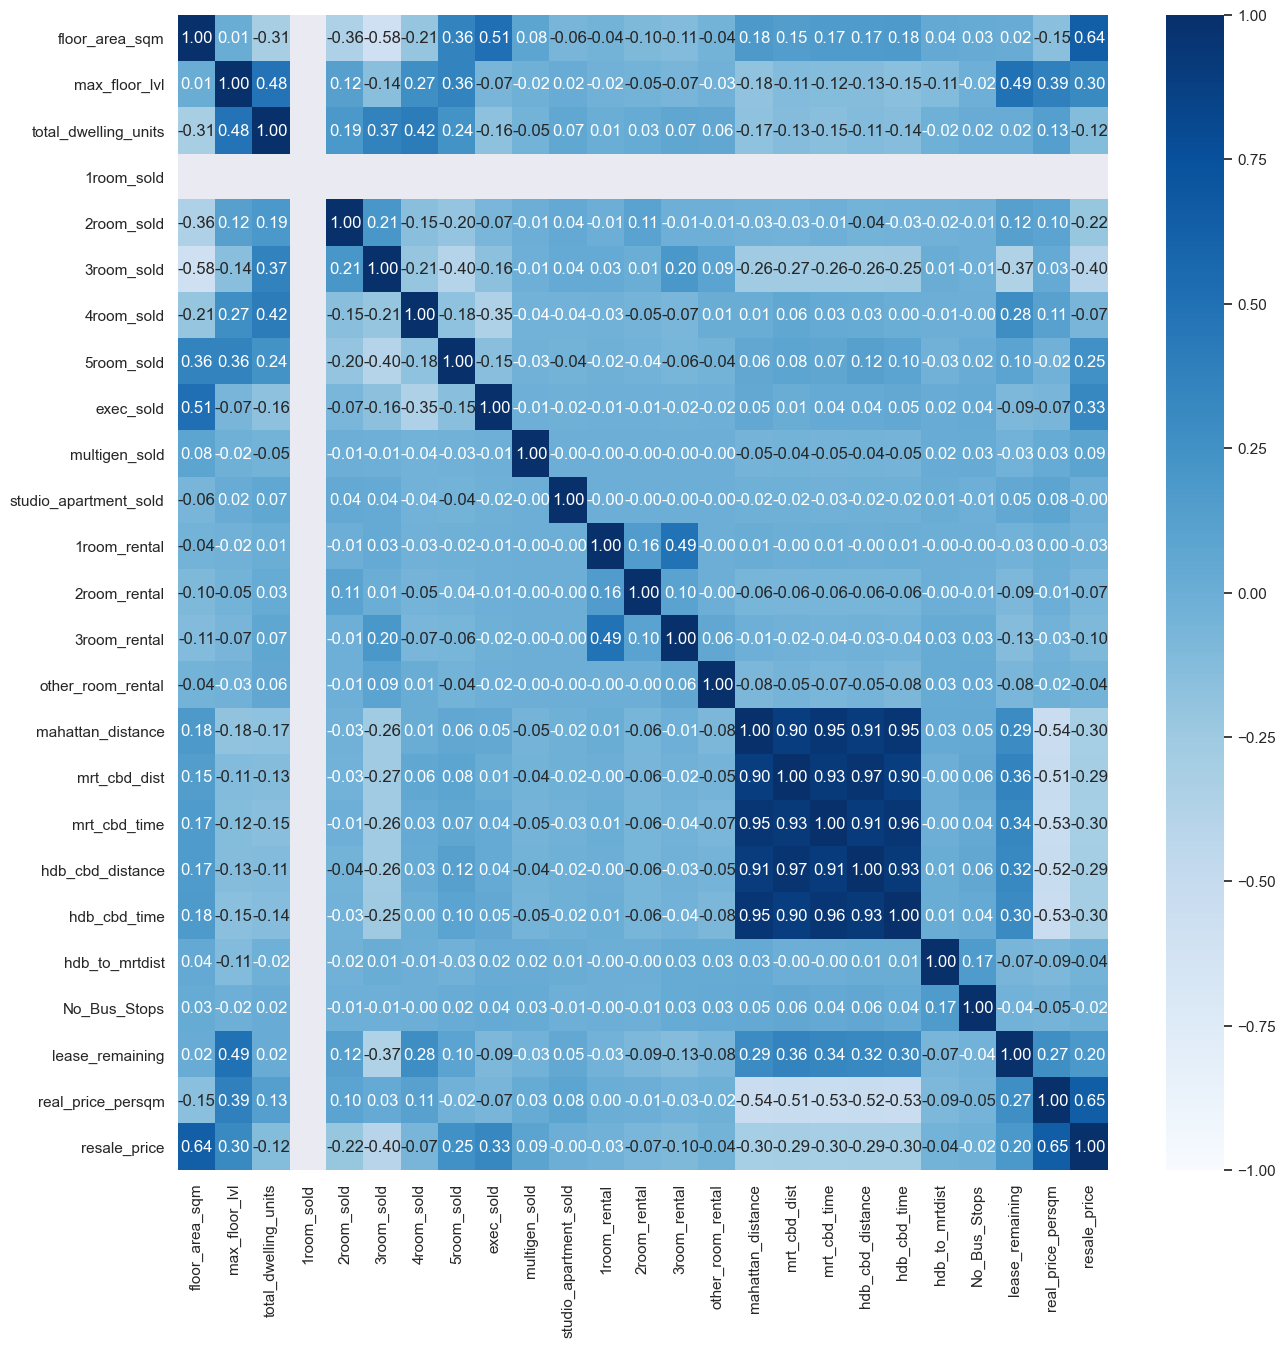

In [8]:
temp = residential[['floor_area_sqm', 'max_floor_lvl',
       'total_dwelling_units', '1room_sold', '2room_sold', '3room_sold',
       '4room_sold', '5room_sold', 'exec_sold', 'multigen_sold',
       'studio_apartment_sold', '1room_rental', '2room_rental', '3room_rental',
       'other_room_rental', 'mahattan_distance',
       'mrt_cbd_dist', 'mrt_cbd_time', 'hdb_cbd_distance', 'hdb_cbd_time',
       'hdb_to_mrtdist', 'No_Bus_Stops', 'lease_remaining', 'real_price_persqm','resale_price']]
f = plt.figure(figsize=(15,15))
sb.heatmap(temp.corr(),  vmin = -1, vmax = 1, annot = True, fmt=".2f", cmap ="Blues")

### High Variance inflation factors 

The VIFs measures the extent to which multicollinearity has increased the variance of an estimated coefficient. It looks at the extent to which an explanatory variable can be explained by all other explanatory variables in the equations. <br>
Reference:
https://www.sfu.ca/~dsignori/buec333/lecture%2016.pdf

If VIF>5, R squared is more than 0.8. So we shall remove the variables 

From the above heatmap, the following variables is easily explained by another:
1. manhattan distance
2. mrt_cbd_dist
3. mrt_cbd_time
4. hdb_cbd_dist
5. hdb_cbd_time

Among all of them, we shall keep the distance from hdb to the cbd (hdb_cbd_dist). 

#### Factors that affect real_price
Using the heatmap above, we can roughly gauge which x variables have a `linear` relationship with the y variable of `real_price_persqm`. Anything above 0 is considered. Later, t-test and p-values will be used to test if they are significant. 
This is almost all factors!

# Running OLS again but without the problematic variables 

In [9]:

X = residential[['floor_area_sqm','Floor_Height',
       'total_dwelling_units', '1room_sold', '2room_sold', '3room_sold',
       '4room_sold', '5room_sold', 'exec_sold', 'multigen_sold',
       'studio_apartment_sold', '1room_rental', '2room_rental', '3room_rental',
       'other_room_rental','hdb_cbd_distance',
       'hdb_to_mrtdist', 'No_Bus_Stops', 'lease_remaining']]
y = residential[['real_price']]
X_constant = sm.add_constant(X)
lr = sm.OLS(y, X_constant.astype(float)).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:             real_price   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                 1.596e+04
Date:                Wed, 05 Apr 2023   Prob (F-statistic):               0.00
Time:                        22:19:58   Log-Likelihood:            -1.4002e+06
No. Observations:              111026   AIC:                         2.800e+06
Df Residuals:                  111008   BIC:                         2.801e+06
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  -585.19

# Could it be categorical variables?

So we know there are a few categorical variables in this dataset!


1. 'month'
2. 'town'
3. 'flat_type'
4. 'street'
5. 'storey_range'
6. 'flat_model'
7. 'year_completed',
8. 'bldg_contract_town'
9. 'building'
10. 'SUBZONE_NO'
11. 'SUBZONE_N'
12. 'PLN_AREA_N'
13. 'REGION_N'
14. 'MRT_NAME'
15. 'MRT_ID'
16. 'mrt_line'
17. 'Floor_Height'


What we are going to do now is split the dataset into the flat type and regions (west, east, north, north-east, central). 
This should effectively remove 1room_sold, 2room_sold etc. variables 

In [10]:
residential['ln_real_price'] = residential.apply(lambda row: np.log(row.real_price), axis=1)
def create_data(room, region):
    temp1 = residential[residential['flat_type'] == room]
    dataset = temp1[temp1['REGION_N']==region]
    title = room + ' '+region+'.csv'
    dataset.to_csv(title, index=False)

In [11]:
for item in ['4 ROOM', '5 ROOM', '3 ROOM', '2 ROOM', 'EXECUTIVE', 'MULTI-GENERATION']:
    for item2 in ['WEST REGION', 'CENTRAL REGION', 'EAST REGION', 'NORTH REGION', 'NORTH-EAST REGION']:
        print(item+ " "+item2)
        create_data(item, item2)

4 ROOM WEST REGION
4 ROOM CENTRAL REGION
4 ROOM EAST REGION
4 ROOM NORTH REGION
4 ROOM NORTH-EAST REGION
5 ROOM WEST REGION
5 ROOM CENTRAL REGION
5 ROOM EAST REGION
5 ROOM NORTH REGION
5 ROOM NORTH-EAST REGION
3 ROOM WEST REGION
3 ROOM CENTRAL REGION
3 ROOM EAST REGION
3 ROOM NORTH REGION
3 ROOM NORTH-EAST REGION
2 ROOM WEST REGION
2 ROOM CENTRAL REGION
2 ROOM EAST REGION
2 ROOM NORTH REGION
2 ROOM NORTH-EAST REGION
EXECUTIVE WEST REGION
EXECUTIVE CENTRAL REGION
EXECUTIVE EAST REGION
EXECUTIVE NORTH REGION
EXECUTIVE NORTH-EAST REGION
MULTI-GENERATION WEST REGION
MULTI-GENERATION CENTRAL REGION
MULTI-GENERATION EAST REGION
MULTI-GENERATION NORTH REGION
MULTI-GENERATION NORTH-EAST REGION


# Lets do regression!

In [12]:
from scipy.stats import chi2
def highlight(s):
    color = 'blue'
    return 'background-color: % s' % color



In [13]:


comp_table = pd.DataFrame({'Variables': ['Constant', 'floor_area_sqm',
               'hdb_cbd_distance', 
               'hdb_to_mrtdist',
               'No_Bus_Stops', 
               'lease_remaining', 
               'Floor_Height', 'R Squared', ' Adjusted R Squared', 'Observations']} )

for item in ['4 ROOM', '5 ROOM', '3 ROOM', '2 ROOM', 'EXECUTIVE', 'MULTI-GENERATION']:
    for item2 in ['WEST REGION', 'CENTRAL REGION', 'EAST REGION', 'NORTH REGION', 'NORTH-EAST REGION']:
        print("\n-------------------------------------------------------------------------------------------------------")
        title = item + ' '+item2+'.csv'
        print("\n\n" + item+ " "+item2 + "\n")
        temp1 = pd.read_csv(title, low_memory=False, index_col=0)
        try:
               
            X = temp1[[
                'floor_area_sqm',
            'hdb_cbd_distance', 
          'hdb_to_mrtdist',
            'No_Bus_Stops', 
           'lease_remaining', 
           'Floor_Height'
                      ]]
            
            y = temp1[['ln_real_price']]
            X_constant = sm.add_constant(X)
            lr = sm.OLS(y, X_constant.astype(float)).fit(cov_type='HC1')
            llist =  []
            
            for i in range(0,7):
               
                    
                coeff = "{:.5f}".format(lr.params[i])
                se = "{:.5f}".format(lr.bse[i])
                str_val = coeff
                if lr.pvalues[i]>=0.05 and lr.pvalues[i]<0.1:
                    str_val += "*"
                elif lr.pvalues[i]<0.05 and lr.pvalues[i]>=0.01: 
                    str_val += "**"
                elif lr.pvalues[i]<0.01:
                    str_val += "***"
                str_val = str_val + "("+se+")"
                if i==1 and lr.params[i]<0.0:
                    str_val = str_val + "  FLOOR AREA IS ANOMALY"
                elif i==2 and lr.params[i]>0.0:
                    str_val = str_val + "  HDB CBD IS ANOMALY"
                elif i==3 and lr.params[i]>0.0:
                    str_val = str_val + "  HDB MRT IS ANOMALY"
                elif i==4 and lr.params[i]<0.0:
                    str_val = str_val + "  Bus Stop IS ANOMALY"
                elif i==5 and lr.params[i]<0.0:
                    str_val = str_val + "  Lease IS ANOMALY"
                llist.append(str_val)
            
            llist.append("{:.5f}".format(lr.rsquared))
            llist.append("{:.5f}".format(lr.rsquared_adj))
            llist.append(str(int(lr.nobs)))
            col_name = item.lower() + " "+item2[:-7].lower()
            add_col = pd.DataFrame({col_name:llist})
            comp_table = pd.concat([comp_table, add_col], axis = 1)
                
            print(lr.summary())
            
    
    
#             print("\nHeteroskedasticity test using breush pagan\n")
#             residuals_squared = lr.resid**2
#             bp_model = sm.OLS(residuals_squared, X_constant.astype(float)).fit()
#             print(bp_model.summary())
#             df_resid = bp_model.df_resid
#             k_vars = bp_model.df_model
#             t_stat = bp_model.ssr/bp_model.mse_resid
#             p_val = chi2.sf(t_stat, k_vars)
#             print(f"BP test p-value: {p_val}")
        
            

            
        except Exception as e:
            print("Error is: ", e)
        print("-------------------------------------------------------------------------------------------------------\n")
    




-------------------------------------------------------------------------------------------------------


4 ROOM WEST REGION

                            OLS Regression Results                            
Dep. Variable:          ln_real_price   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.360
Method:                 Least Squares   F-statistic:                     1051.
Date:                Wed, 05 Apr 2023   Prob (F-statistic):               0.00
Time:                        22:20:08   Log-Likelihood:                 6316.1
No. Observations:                7562   AIC:                        -1.262e+04
Df Residuals:                    7555   BIC:                        -1.257e+04
Df Model:                           6                                         
Covariance Type:                  HC1                                         
                       coef    std err          z      P>|z|      [0.025      0.975

                            OLS Regression Results                            
Dep. Variable:          ln_real_price   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     1025.
Date:                Wed, 05 Apr 2023   Prob (F-statistic):               0.00
Time:                        22:20:08   Log-Likelihood:                 19078.
No. Observations:               27386   AIC:                        -3.814e+04
Df Residuals:                   27379   BIC:                        -3.809e+04
Df Model:                           6                                         
Covariance Type:                  HC1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               12.2029      0.037  

                            OLS Regression Results                            
Dep. Variable:          ln_real_price   R-squared:                       0.513
Model:                            OLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                     2474.
Date:                Wed, 05 Apr 2023   Prob (F-statistic):               0.00
Time:                        22:20:09   Log-Likelihood:                 12605.
No. Observations:               17386   AIC:                        -2.520e+04
Df Residuals:                   17379   BIC:                        -2.514e+04
Df Model:                           6                                         
Covariance Type:                  HC1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               10.7617      0.039  

                            OLS Regression Results                            
Dep. Variable:          ln_real_price   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.642
Method:                 Least Squares   F-statistic:                     119.8
Date:                Wed, 05 Apr 2023   Prob (F-statistic):           5.97e-70
Time:                        22:20:10   Log-Likelihood:                 500.92
No. Observations:                 252   AIC:                            -987.8
Df Residuals:                     245   BIC:                            -963.1
Df Model:                           6                                         
Covariance Type:                  HC1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               12.0281      0.507  

                            OLS Regression Results                            
Dep. Variable:          ln_real_price   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                     170.2
Date:                Wed, 05 Apr 2023   Prob (F-statistic):          2.11e-178
Time:                        22:20:10   Log-Likelihood:                 1783.2
No. Observations:                2230   AIC:                            -3552.
Df Residuals:                    2223   BIC:                            -3512.
Df Model:                           6                                         
Covariance Type:                  HC1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               13.2298      0.147  

                            OLS Regression Results                            
Dep. Variable:          ln_real_price   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     1950.
Date:                Wed, 05 Apr 2023   Prob (F-statistic):               0.00
Time:                        22:20:10   Log-Likelihood:                 4246.5
No. Observations:                3587   AIC:                            -8479.
Df Residuals:                    3580   BIC:                            -8436.
Df Model:                           6                                         
Covariance Type:                  HC1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               15.1385      0.079  

In [14]:
comp_table.to_csv('results.csv')

In [15]:
comp_table

,Variables,4 room west,4 room central,4 room east,4 room north,4 room north-east,5 room west,5 room central,5 room east,5 room north,...,3 room north-east,2 room west,2 room central,2 room east,2 room north-east,executive west,executive central,executive east,executive north,executive north-east
0,Constant,12.62943***(0.04662),11.98812***(0.02740),11.90488***(0.01628),12.08703***(0.02515),12.20291***(0.03741),12.53584***(0.07268),12.55185***(0.06722),13.32846***(0.04972),12.00640***(0.06049),...,11.70647***(0.04354),12.02810***(0.50715),11.45545***(0.13238),10.43273***(0.08770),11.23013***(0.06798),13.22977***(0.14692),12.07145***(0.14164),12.99215***(0.07648),14.41766***(0.25522),15.13850***(0.07943)
1,floor_area_sqm,-0.00035(0.00027) FLOOR AREA IS ANOMALY,0.00702***(0.00026),0.00354***(0.00015),0.00706***(0.00022),0.00291***(0.00038),0.00306***(0.00036),0.00207***(0.00046),-0.00451***(0.00035) FLOOR AREA IS ANOMALY,0.00841***(0.00028),...,0.00754***(0.00053),0.00238(0.00697),0.00893***(0.00233),0.03510***(0.00245),0.01702***(0.00119),0.00217***(0.00066),0.00565***(0.00054),0.00437***(0.00045),0.00472***(0.00050),-0.00226***(0.00037) FLOOR AREA IS ANOMALY
2,hdb_cbd_distance,-0.00001***(0.00000),-0.00002***(0.00000),-0.00001***(0.00000),-0.00003***(0.00000),-0.00001***(0.00000),-0.00002***(0.00000),0.00000(0.00000) HDB CBD IS ANOMALY,-0.00001***(0.00000),-0.00003***(0.00000),...,0.00001***(0.00000) HDB CBD IS ANOMALY,-0.00001(0.00001),0.00001(0.00000) HDB CBD IS ANOMALY,-0.00002***(0.00001),0.00002***(0.00000) HDB CBD IS ANOMALY,-0.00003***(0.00000),0.00002***(0.00000) HDB CBD IS ANOMALY,-0.00001***(0.00000),-0.00004***(0.00000),-0.00006***(0.00000)
3,hdb_to_mrtdist,-0.00000(0.00000),-0.00004***(0.00001),-0.00006***(0.00000),-0.00002***(0.00001),-0.00004***(0.00000),-0.00001**(0.00000),-0.00006***(0.00001),-0.00003***(0.00000),-0.00002***(0.00001),...,0.00001(0.00000) HDB MRT IS ANOMALY,-0.00005**(0.00002),0.00001(0.00001) HDB MRT IS ANOMALY,-0.00000(0.00001),-0.00000(0.00001),0.00001(0.00001) HDB MRT IS ANOMALY,-0.00009***(0.00001),-0.00004***(0.00000),0.00000(0.00001) HDB MRT IS ANOMALY,-0.00002***(0.00001)
4,No_Bus_Stops,-0.00145***(0.00031) Bus Stop IS ANOMALY,0.00277***(0.00051),0.00424***(0.00033),-0.00818***(0.00039) Bus Stop IS ANOMALY,-0.00123***(0.00025) Bus Stop IS ANOMALY,-0.00124***(0.00038) Bus Stop IS ANOMALY,0.00198***(0.00059),0.00563***(0.00043),-0.00513***(0.00040) Bus Stop IS ANOMALY,...,-0.00206***(0.00037) Bus Stop IS ANOMALY,0.00138**(0.00057),0.00253(0.00247),-0.00088(0.00264) Bus Stop IS ANOMALY,0.00277***(0.00068),0.00506***(0.00072),0.00693***(0.00121),-0.00475***(0.00055) Bus Stop IS ANOMALY,-0.00552***(0.00123) Bus Stop IS ANOMALY,-0.00473***(0.00047) Bus Stop IS ANOMALY
5,lease_remaining,0.00608***(0.00019),0.00928***(0.00013),0.01183***(0.00012),0.00911***(0.00020),0.00716***(0.00017),0.00637***(0.00029),0.00930***(0.00027),0.00808***(0.00020),0.00789***(0.00028),...,0.00423***(0.00017),0.00323(0.00220),0.00543***(0.00072),0.00837***(0.00085),0.00077(0.00049),0.00207**(0.00084),0.00831***(0.00131),-0.00001(0.00040) Lease IS ANOMALY,-0.01272***(0.00259) Lease IS ANOMALY,-0.00594***(0.00054) Lease IS ANOMALY
6,Floor_Height,0.00724***(0.00024),0.01051***(0.00020),0.00956***(0.00031),0.00728***(0.00032),0.00663***(0.00014),0.00851***(0.00024),0.00665***(0.00022),0.01236***(0.00032),0.00922***(0.00035),...,0.00470***(0.00019),0.00604***(0.00027),0.00660***(0.00111),0.00462***(0.00083),0.00582***(0.00023),0.00813***(0.00050),0.00916***(0.00043),0.00777***(0.00045),0.00701***(0.00085),0.00798***(0.00031)
7,R Squared,0.36015,0.78256,0.70109,0.63988,0.22657,0.35642,0.67591,0.67966,0.47081,...,0.52427,0.65071,0.26266,0.82843,0.43228,0.30101,0.56020,0.33403,0.70387,0.79342
8,Adjusted R Squared,0.35965,0.78228,0.70082,0.63921,0.22640,0.35586,0.67518,0.67925,0.46952,...,0.52368,0.64216,0.25168,0.82357,0.42894,0.29912,0.55571,0.33245,0.69892,0.79307
9,Observations,7562,4617,6617,3235,27386,6891,2674,4702,2461,

In [16]:
import itertools
y = list(comp_table.columns[1:])
x = comp_table.loc[2].values[1:].tolist()
x = [float(i)*100 for i in x]
obs = comp_table.loc[9].values[1:].tolist()
obs = [int(i) for i in obs]
print(obs)
df = pd.DataFrame(columns=['Flat Type/Region','HDB CBD Distance', 'Flat_Type'])
for i in range(0, len(y)):
    ftype = str(y[i])
    if obs[i]<500:
        print(ftype)
    else:
        df = df.append({'Flat Type/Region':y[i], 'HDB CBD Distance':x[i], 'Flat_Type':ftype[:6]}, ignore_index=True)
sb.set_palette(sb.color_palette('dark'))
plt.figure(figsize=(10,5))
plt.title('Beta3 HDB CBD Distance for Different Flat Type in Different Region')
ax = None
ax = sb.barplot(
    data=df, x="HDB CBD Distance", y="Flat Type/Region",color='b'
)



plt.show()

ValueError: could not convert string to float: '-0.00001***(0.00000)'

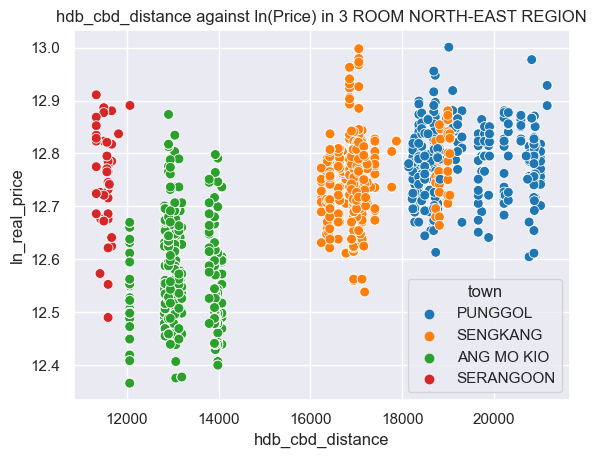

In [36]:
#temp = residential[residential['REGION_N']=='NORTH-EAST REGION']
title = '3 ROOM EAST '+'REGION' 
title1 = title + '.csv'
temp = pd.read_csv(title1, low_memory=False, index_col=0)
# print(temp)
X=temp[['hdb_cbd_distance']]
Y=temp[['ln_real_price']]


titlestr = 'hdb_cbd_distance against ln(Price) in ' + title
sb.set_palette(sb.color_palette('tab10'))
regressor = LinearRegression()
regressor.fit(X,Y)
y_pred = regressor.predict(X)
plt.scatter(X, Y, color = 'blue',s=2)
sb.scatterplot(x='hdb_cbd_distance', y='ln_real_price',hue='town', data=temp,s=50)
# plt.plot(X, regressor.predict(X), color = 'red', linewidth=5)
plt.title(titlestr)
plt.xlabel('hdb_cbd_distance')
plt.ylabel('ln_real_price')
plt.show()


# temp = residential[residential['REGION_N']=='CENTRAL REGION']
# title = 'CENTRAL '+'REGION' #+'.csv'
# # temp = pd.read_csv(title, low_memory=False, index_col=0)
# # print(temp)
# X=temp[['No_Bus_Stops']]
# Y=temp[['lease_remaining']]


# titlestr = 'Bus Stop Against Price in ' + title
# sb.set_palette(sb.color_palette('tab10'))
# regressor = LinearRegression()
# regressor.fit(X,Y)
# y_pred = regressor.predict(X)
# plt.scatter(X, Y, color = 'blue',s=2)
# sb.scatterplot(x='No_Bus_Stops', y='lease_remaining',hue='town', data=temp,s=50)
# # plt.plot(X, regressor.predict(X), color = 'red', linewidth=5)
# plt.title(titlestr)
# plt.xlabel('No_Bus_Stops')
# plt.ylabel('lease_remaining')
# plt.show()


#-------------------------------------

# t1 = temp[temp['town'] == 'BISHAN']
# t2 = temp[temp['town'] == 'GEYLANG']
# t3 = temp[temp['town'] == 'TOA PAYOH']
# t4 = temp[temp['town'] == 'KALLANG/WHAMPOA']
# t5 = temp[temp['town'] == 'BUKIT TIMAH']
# t6 = temp[temp['town'] == 'QUEENSTOWN']
# print("Average BISHAN real_price: " , t1.loc[:, 'real_price'].mean())
# print("Average BISHAN hdb_cbd_distance: ",t1.loc[:, 'hdb_cbd_distance'].mean())

# print()
# print("Average GEYLANG real_price: ",t2.loc[:, 'real_price'].mean())
# print("Average GEYLANG hdb_cbd_distance: ",t2.loc[:, 'hdb_cbd_distance'].mean())

# print()
# print("Average TOA PAYOH RIS real_price: ",t3.loc[:, 'real_price'].mean())
# print("Average TOA PAYOH RIS hdb_cbd_distance: ",t3.loc[:, 'hdb_cbd_distance'].mean())

# print()
# print("Average KALLANG/WHAMPOA real_price: ",t4.loc[:, 'real_price'].mean())
# print("Average KALLANG/WHAMPOA hdb_cbd_distance: ",t4.loc[:, 'hdb_cbd_distance'].mean())
# print()

# print("Average BUKIT TIMAH real_price: ",t5.loc[:, 'real_price'].mean())
# print("Average BUKIT TIMAH hdb_cbd_distance: ",t5.loc[:, 'hdb_cbd_distance'].mean())
# print()

# print("Average QUEENSTOWN real_price: ",t5.loc[:, 'real_price'].mean())
# print("Average QUEENSTOWN hdb_cbd_distance: ",t5.loc[:, 'hdb_cbd_distance'].mean())
# print()

In [18]:
def create_data_town(town, df):
    temp1 = df[df['town'] == town]
    if town == 'KALLANG/WHAMPOA':
        title = 'KALLANG WHAMPOA.csv'
    else:
        title = town + '.csv'
    
    print(title)
    temp1.to_csv(title, index=False)

In [19]:
temp = pd.read_csv('EXECUTIVE CENTRAL REGION.csv', low_memory=False, index_col=0)
llist1 = temp['town'].unique().tolist()
for item in llist1:
    create_data_town(item, temp)

BISHAN.csv
GEYLANG.csv
TOA PAYOH.csv
KALLANG WHAMPOA.csv
BUKIT TIMAH.csv
QUEENSTOWN.csv


In [20]:
comp_table = pd.DataFrame({'Variables': ['Constant', 'floor_area_sqm',
               'hdb_cbd_distance', 
               'hdb_to_mrtdist',
               'No_Bus_Stops', 
               'lease_remaining', 
               'Floor_Height', 'R Squared', ' Adjusted R Squared', 'Observations']} )

for town in llist1:
        print("\n-------------------------------------------------------------------------------------------------------")
        if town == 'KALLANG/WHAMPOA':
            title = 'KALLANG WHAMPOA.csv'
        else:
            title = town + '.csv'
        print("\n\n" + town+ "\n")
        temp1 = pd.read_csv(title, low_memory=False, index_col=0)
        try:
               
            X = temp1[[
                'floor_area_sqm',
            'hdb_cbd_distance', 
          'hdb_to_mrtdist',
            'No_Bus_Stops', 
           'lease_remaining', 
           'Floor_Height'
                      ]]
            
            y = temp1[['ln_real_price']]
            X_constant = sm.add_constant(X)
            lr = sm.OLS(y, X_constant.astype(float)).fit(cov_type='HC1')
            llist =  []
            
            for i in range(0,7):
                coeff = "{:.4f}".format(lr.params[i])
                se = "{:.4f}".format(lr.bse[i])
                str_val = coeff
                
                if lr.pvalues[i]>=0.05 and lr.pvalues[i]<0.1:
                    str_val += "*"
                elif lr.pvalues[i]<0.05 and lr.pvalues[i]>=0.01: 
                    str_val += "**"
                elif lr.pvalues[i]<0.01:
                    str_val += "***"
                str_val = str_val + "("+se+")"
                llist.append(str_val)
            
            llist.append("{:.4f}".format(lr.rsquared))
            llist.append("{:.4f}".format(lr.rsquared_adj))
            llist.append(str(int(lr.nobs)))
            col_name = town.upper()
            add_col = pd.DataFrame({col_name:llist})
            comp_table = pd.concat([comp_table, add_col], axis = 1)
                
            print(lr.summary())
        
    
    
#             print("\nHeteroskedasticity test using breush pagan\n")
#             residuals_squared = lr.resid**2
#             bp_model = sm.OLS(residuals_squared, X_constant.astype(float)).fit()
#             print(bp_model.summary())
#             df_resid = bp_model.df_resid
#             k_vars = bp_model.df_model
#             t_stat = bp_model.ssr/bp_model.mse_resid
#             p_val = chi2.sf(t_stat, k_vars)
#             print(f"BP test p-value: {p_val}")
        
            

            
        except Exception as e:
            print("Error is: ", e)
            print(e)
        print("-------------------------------------------------------------------------------------------------------\n")
    




-------------------------------------------------------------------------------------------------------


BISHAN

                            OLS Regression Results                            
Dep. Variable:          ln_real_price   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     135.5
Date:                Mon, 03 Apr 2023   Prob (F-statistic):           7.50e-82
Time:                        19:00:01   Log-Likelihood:                 401.97
No. Observations:                 303   AIC:                            -789.9
Df Residuals:                     296   BIC:                            -763.9
Df Model:                           6                                         
Covariance Type:                  HC1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
----------

C:\Users\samik\Anaconda3\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 5
  warnings.warn('covariance of constraints does not have full '
C:\Users\samik\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\samik\Anaconda3\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 5
  warnings.warn('covariance of constraints does not have full '


In [21]:
comp_table

,Variables,BISHAN,GEYLANG,TOA PAYOH,BUKIT TIMAH,QUEENSTOWN
0,Constant,13.5404***(0.2395),13.4664***(0.4077),10.5822***(0.4475),13.7350***(0.6534),0.0000***(0.0000)
1,floor_area_sqm,0.0019***(0.0007),0.0054***(0.0019),0.0064***(0.0011),0.0049*(0.0025),0.0080*(0.0045)
2,hdb_cbd_distance,-0.0000(0.0000),-0.0000***(0.0000),0.0001(0.0001),0.0000*(0.0000),0.0022***(0.0001)
3,hdb_to_mrtdist,0.0000(0.0000),-0.0000*(0.0000),-0.0007***(0.0001),0.0001(0.0001),-0.0010***(0.0004)
4,No_Bus_Stops,-0.0008(0.0015),0.0297***(0.0071),0.0601***(0.0061),0.0000***(0.0000),0.0000(0.0000)
5,lease_remaining,-0.0026(0.0026),-0.0072(0.0052),0.0263***(0.0051),-0.0180***(0.0047),-0.0359***(0.0100)
6,Floor_Height,0.0114***(0.0006),0.0080***(0.0014),0.0179***(0.0065),0.0090***(0.0021),0.0152***(0.0028)
7,R Squared,0.7158,0.4795,0.9285,0.4336,0.8366
8,Adjusted R Squared,0.7100,0.4575,0.9194,0.3591,0.7771
9,Observations,303,149,54,44,16


In [22]:
comp_table.to_csv('PrestSchools.csv')